# Transforming Attentions to Representations

Taking the eval_attentions_*.bin that we produced in the extract_attentions.ipynb, and work investigated in transform_representation_exploration.ipynb we validate our process to produce the 2048 value representations of the bert attention matrices.

As before, we transform the matrices into image-like tensors and feed them to barlow twins.  Output is flattened from the 12x12 layer/head groupings and each 2048 tensor is converted to a columnar format.

In [7]:
import torch
import time
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd

helper functions

In [6]:
def plot_layer_heads(attention, num_layers=12, num_heads=12):
  for i in range(0,11):
    p = attention[i]
    fig, axis = plt.subplots(1,12, figsize=(20,5), facecolor='w', edgecolor='k')
    plt.title(f'layer {i}')
    head = 0
    for axs, ph in zip(axis.flatten(), p):
      heatmap = axs.imshow(ph, cmap='hot')

Loading raw attention pkl file

In [7]:
data_dir='/tf/notebooks/QA_attentions_pickled_pretuned'
output_dir='/tf/notebooks/QA_attentions_pickled_pretuned/representations'

In [10]:
batch_num = 100

In [11]:
attentions = torch.load(os.path.join(data_dir, f"eval_attentions_{batch_num}.bin"))

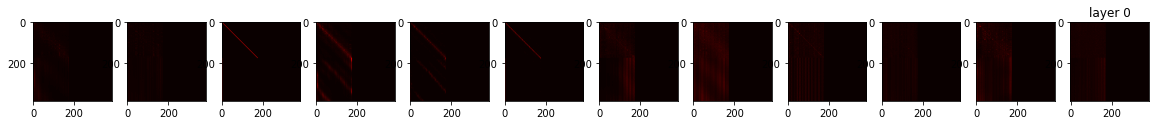

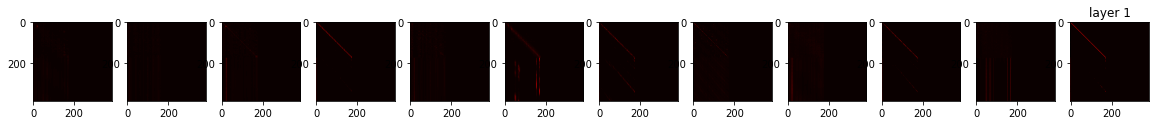

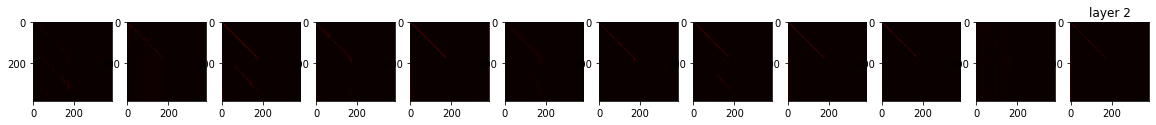

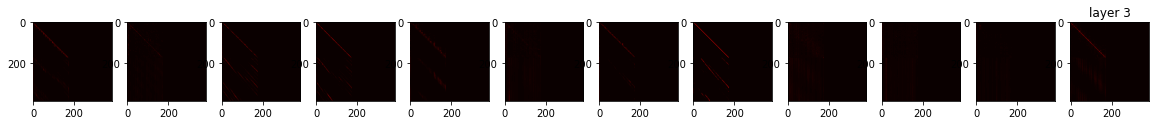

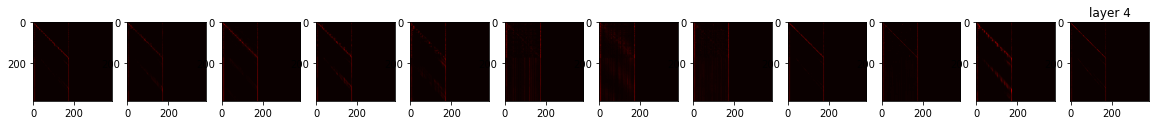

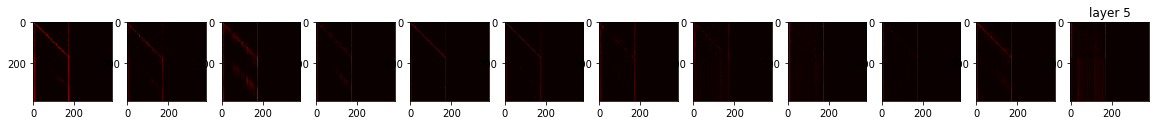

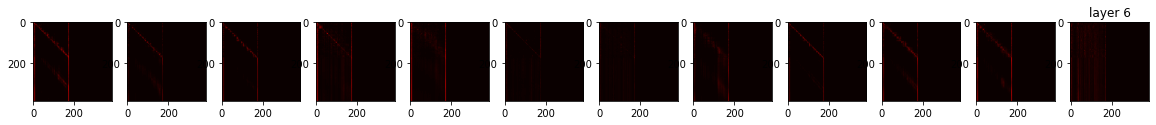

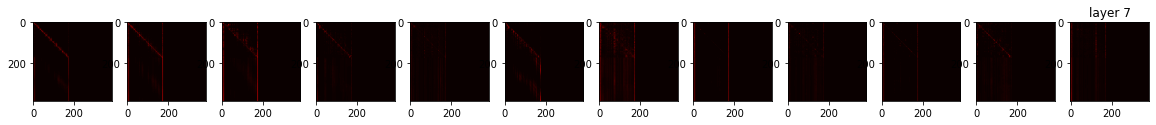

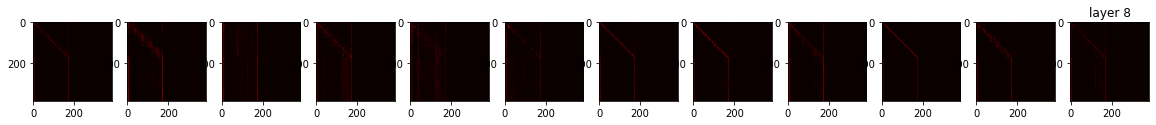

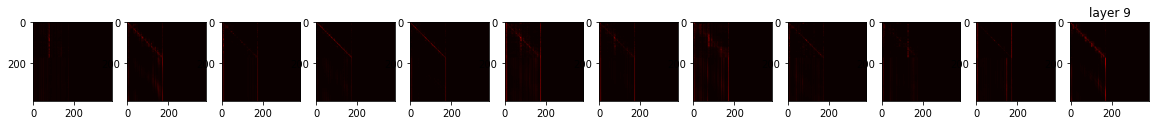

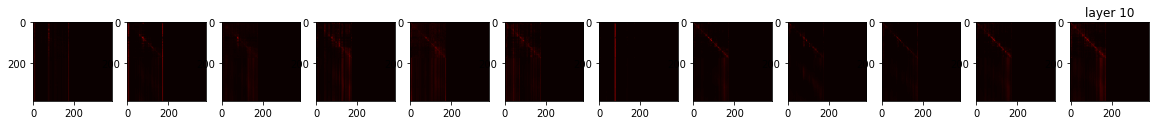

In [12]:
plot_layer_heads(attentions[0])

Scaling attention values to image range for barlow twins input

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 255)) 

In [20]:
def scale_example(example):
    new_example = np.empty(shape=(12,12), dtype=np.ndarray)
    for l, layer in enumerate(example): #12 layers
        new_layer = np.array([])
        for h, head in enumerate(layer): #12 heads
            flat_head_transformed = scaler.fit_transform(head)
            new_example[l,h] = flat_head_transformed.reshape(384,384)
    return new_example

In [21]:
start_time = time.time()
scaled_attentions = []
for example in attentions:
    scaled_attentions.append(scale_example(example))
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.434138774871826 seconds ---


In [16]:
torch.save(scaled_attentions,os.path.join(data_dir, f"scaled_attentions_{batch_num}.bin"))

In [17]:
scaled_attentions = torch.load(os.path.join(data_dir, f"scaled_attentions_{batch_num}.bin"))

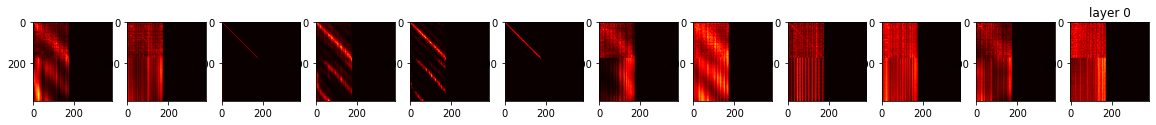

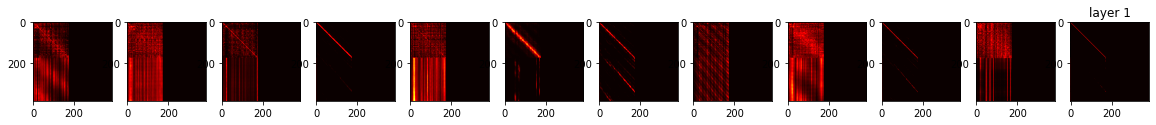

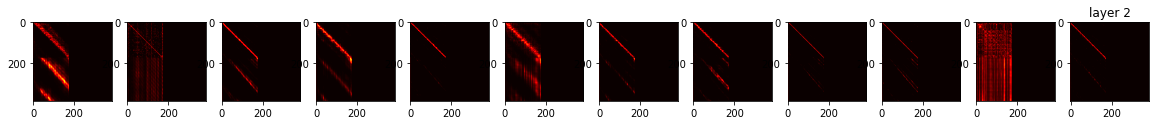

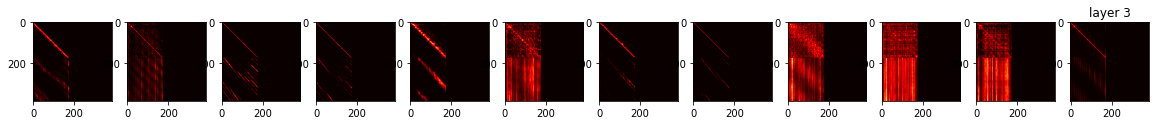

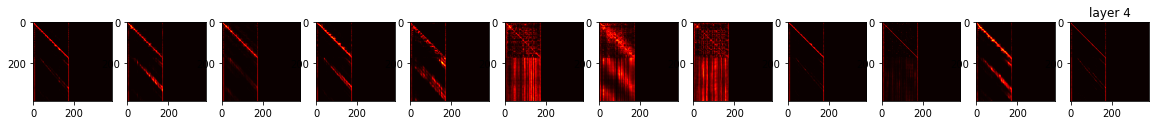

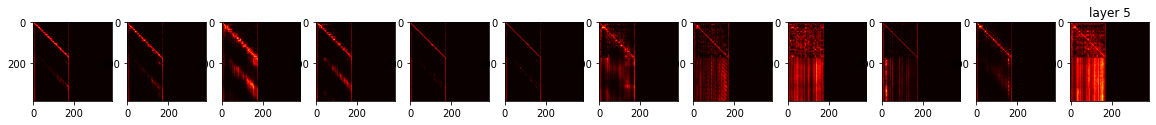

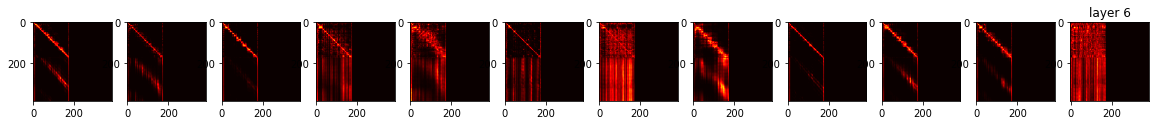

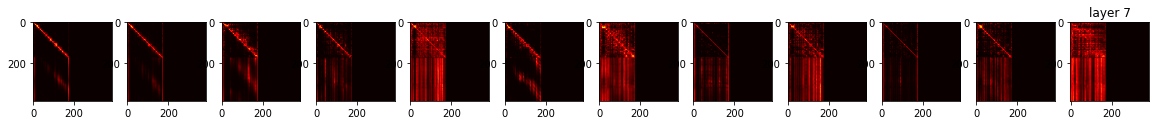

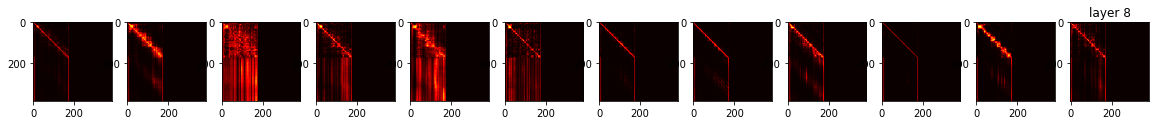

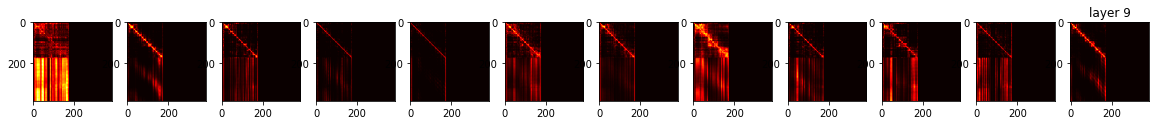

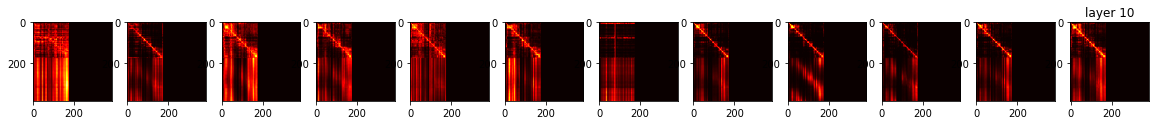

In [22]:
plot_layer_heads(scaled_attentions[0])

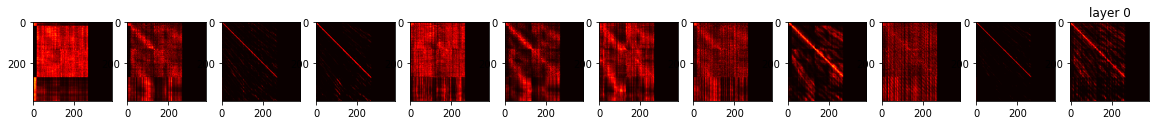

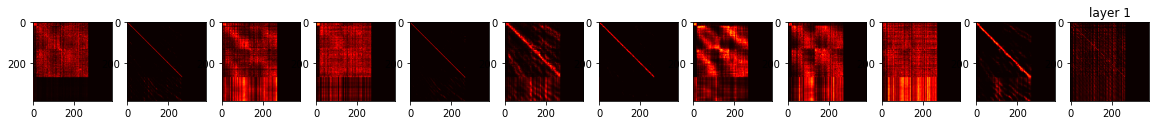

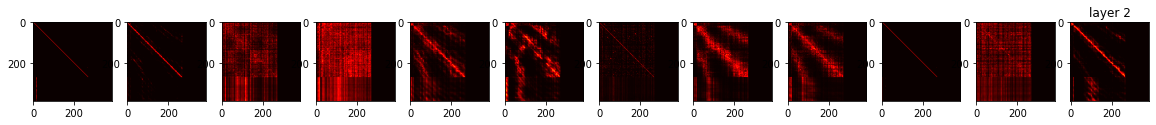

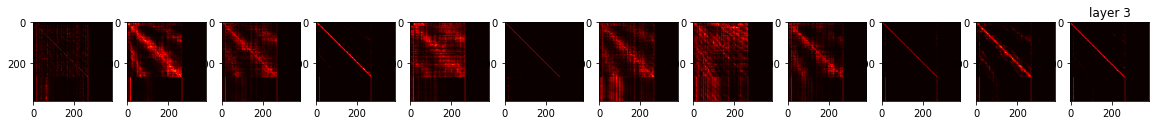

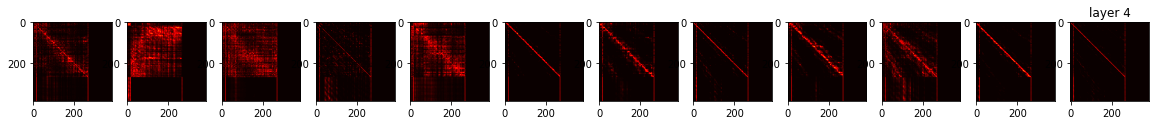

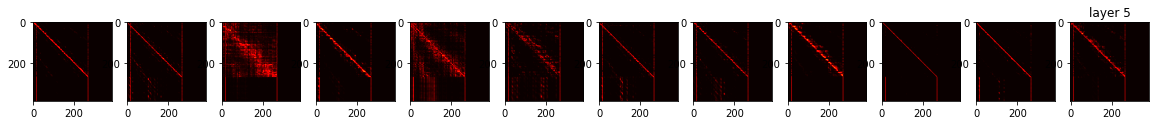

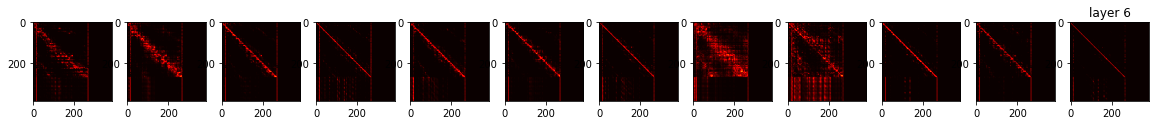

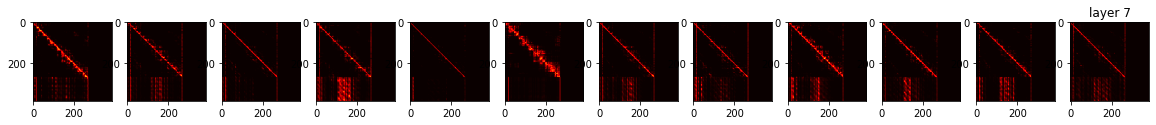

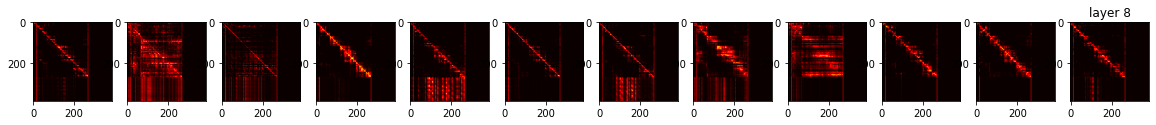

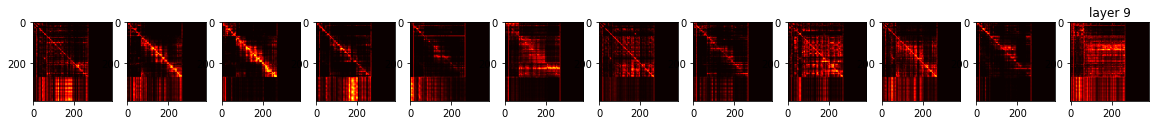

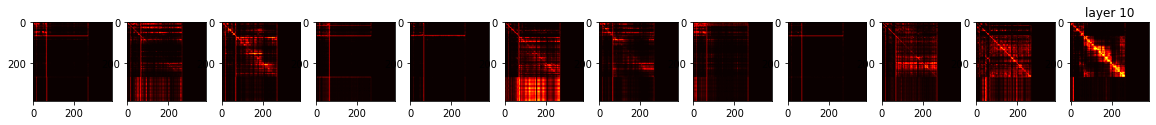

In [42]:
plot_layer_heads(scaled_attentions[0]) #from eval_attentions 200

Convert scaled attentions to representations using trained barlow twins checkpoint

In [9]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x    

In [10]:
model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model.fc = Identity() # pass through values from second to last layer, bypassing linear classifier

Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


In [23]:
#test run of barlow twins minus the linear last layer
x = torch.randn(1, 3, 384, 384)
output = model(x)
print(output.shape)

torch.Size([1, 2048])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [24]:
# create (1, 3, 384, 384) shape expected by barlow twins model
def make_example(image):
    example_channel = np.expand_dims(image, axis=0)
    batch = np.append(example_channel, example_channel, axis=0)
    batch = np.append(batch, example_channel, axis=0)
    example_3channel = np.expand_dims(batch, axis=0)
    return example_3channel

In [25]:
start_time = time.time()

cuda = torch.device('cuda:0')
model.to(cuda)

barlow_representations = np.zeros((100), np.object)
for i, example in enumerate(scaled_attentions):
    reshaped_example = np.zeros((12,12), np.object)
    for l, layer in enumerate(example):
        for h, head in enumerate(layer):
            reshaped_head = torch.from_numpy(make_example(head)).to(cuda)
            representation_head = model(reshaped_head.float())
            reshaped_example[l][h] = representation_head.detach().cpu().numpy()
    barlow_representations[i] = reshaped_example


print("--- %s seconds ---" % (time.time() - start_time))

--- 176.94147729873657 seconds ---


In [26]:
torch.save(barlow_representations, os.path.join(output_dir, f"representation_{batch_num}_test.bin"))

In [27]:
barlow_representations = torch.load(os.path.join(output_dir, f"representation_{batch_num}_test.bin"))

In [29]:
barlow_representations.shape

(100,)

In [33]:
def flatten_layer_heads(representations_tensor):
    flat_array = np.zeros((14400), np.ndarray)
    i = 0
    for example in representations_tensor:
        for layer in example:
            for h, head in enumerate(layer):
                flat_array[i] = head[0]
                i += 1
    return flat_array

In [34]:
flat_representations = flatten_layer_heads(barlow_representations)

In [38]:
df = pd.DataFrame(flat_representations)

In [39]:
df_b = pd.DataFrame([pd.Series(x) for x in df[0]])

In [40]:
df_b.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.019263,0.010018,0.003931,0.041560,0.041569,0.006082,0.009629,0.087735,0.033247,0.046074,...,0.006861,0.078070,0.006589,0.081743,0.045030,0.091617,0.004911,0.052060,0.007085,0.007592
1,0.009762,0.010806,0.020088,0.012746,0.012017,0.021778,0.036868,0.138058,0.053960,0.072066,...,0.011774,0.017502,0.002910,0.098246,0.062684,0.087977,0.013935,0.014411,0.006988,0.012347
2,0.003033,0.008637,0.023540,0.031019,0.055124,0.003223,0.042449,0.094020,0.032669,0.019854,...,0.000977,0.011077,0.005411,0.079976,0.031846,0.024141,0.014484,0.026018,0.000000,0.019646
3,0.018484,0.018399,0.006320,0.028108,0.060860,0.017794,0.039797,0.107537,0.013977,0.027539,...,0.000000,0.010985,0.005731,0.082507,0.019366,0.018046,0.010154,0.018711,0.007658,0.020342
4,0.027147,0.041774,0.006330,0.028542,0.010700,0.027587,0.023513,0.111755,0.005959,0.046889,...,0.012306,0.017159,0.017197,0.111847,0.017148,0.024888,0.019090,0.004244,0.013440,0.040707
5,0.019422,0.016890,0.023891,0.021854,0.013091,0.009512,0.008186,0.121592,0.018657,0.058460,...,0.014800,0.001438,0.005562,0.120273,0.021743,0.039625,0.006669,0.003177,0.007187,0.033042
6,0.030917,0.008798,0.015485,0.030465,0.029474,0.024791,0.080754,0.114038,0.025696,0.049602,...,0.006627,0.030129,0.007499,0.114652,0.022997,0.066956,0.008539,0.020937,0.005726,0.046393
7,0.041327,0.024191,0.010259,0.025790,0.024649,0.005701,0.018978,0.132455,0.052426,0.034666,...,0.005323,0.045057,0.004733,0.080093,0.037573,0.076219,0.004669,0.024252,0.000000,0.036119
8,0.014924,0.039449,0.016020,0.017725,0.014368,0.012110,0.001996,0.158349,0.030301,0.066992,...,0.014843,0.036322,0.011926,0.092172,0.064626,0.053519,0.003075,0.001512,0.010735,0.048815
9,0.030598,0.010081,0.050696,0.026823,0.008213,0.007733,0.031135,0.082502,0.005973,0.052917,...,0.019887,0.025901,0.006365,0.122525,0.032433,0.034038,0.000313,0.015727,0.006184,0.061041
